Number of Time entries 15
Number of entries in frame  156
Timestamp: 9
MISO data entries: [0, 32, 64, 96, 0, 32, 64, 96, 0, 32, 64, 96, 0, 32, 64, 96, 1, 33, 65, 97, 2, 34, 66, 98, 3, 35, 67, 99, 4, 36, 68, 100, 5, 37, 69, 101, 6, 38, 70, 102, 7, 39, 71, 103, 8, 40, 72, 104, 9, 41, 73, 105, 10, 42, 74, 106, 11, 43, 75, 107, 12, 44, 76, 108, 13, 45, 77, 109, 14, 46, 78, 110, 15, 47, 79, 111, 16, 48, 80, 112, 17, 49, 81, 113, 18, 50, 82, 114, 19, 51, 83, 115, 20, 52, 84, 116, 21, 53, 85, 117, 22, 54, 86, 118, 23, 55, 87, 119, 24, 56, 88, 120, 25, 57, 89, 121, 26, 58, 90, 122, 27, 59, 91, 123, 28, 60, 92, 124, 29, 61, 93, 125, 30, 62, 94, 126, 31, 63, 95, 127]
Len MISO data entries: 140
Number of Filler Words: 10
Number of timestamps: 15
Shape of channel data: 15 x 128
Shape of aux data: 15 x 12

Checking channel alignment...
Done Checking channel alignment
Channel data is aligned!



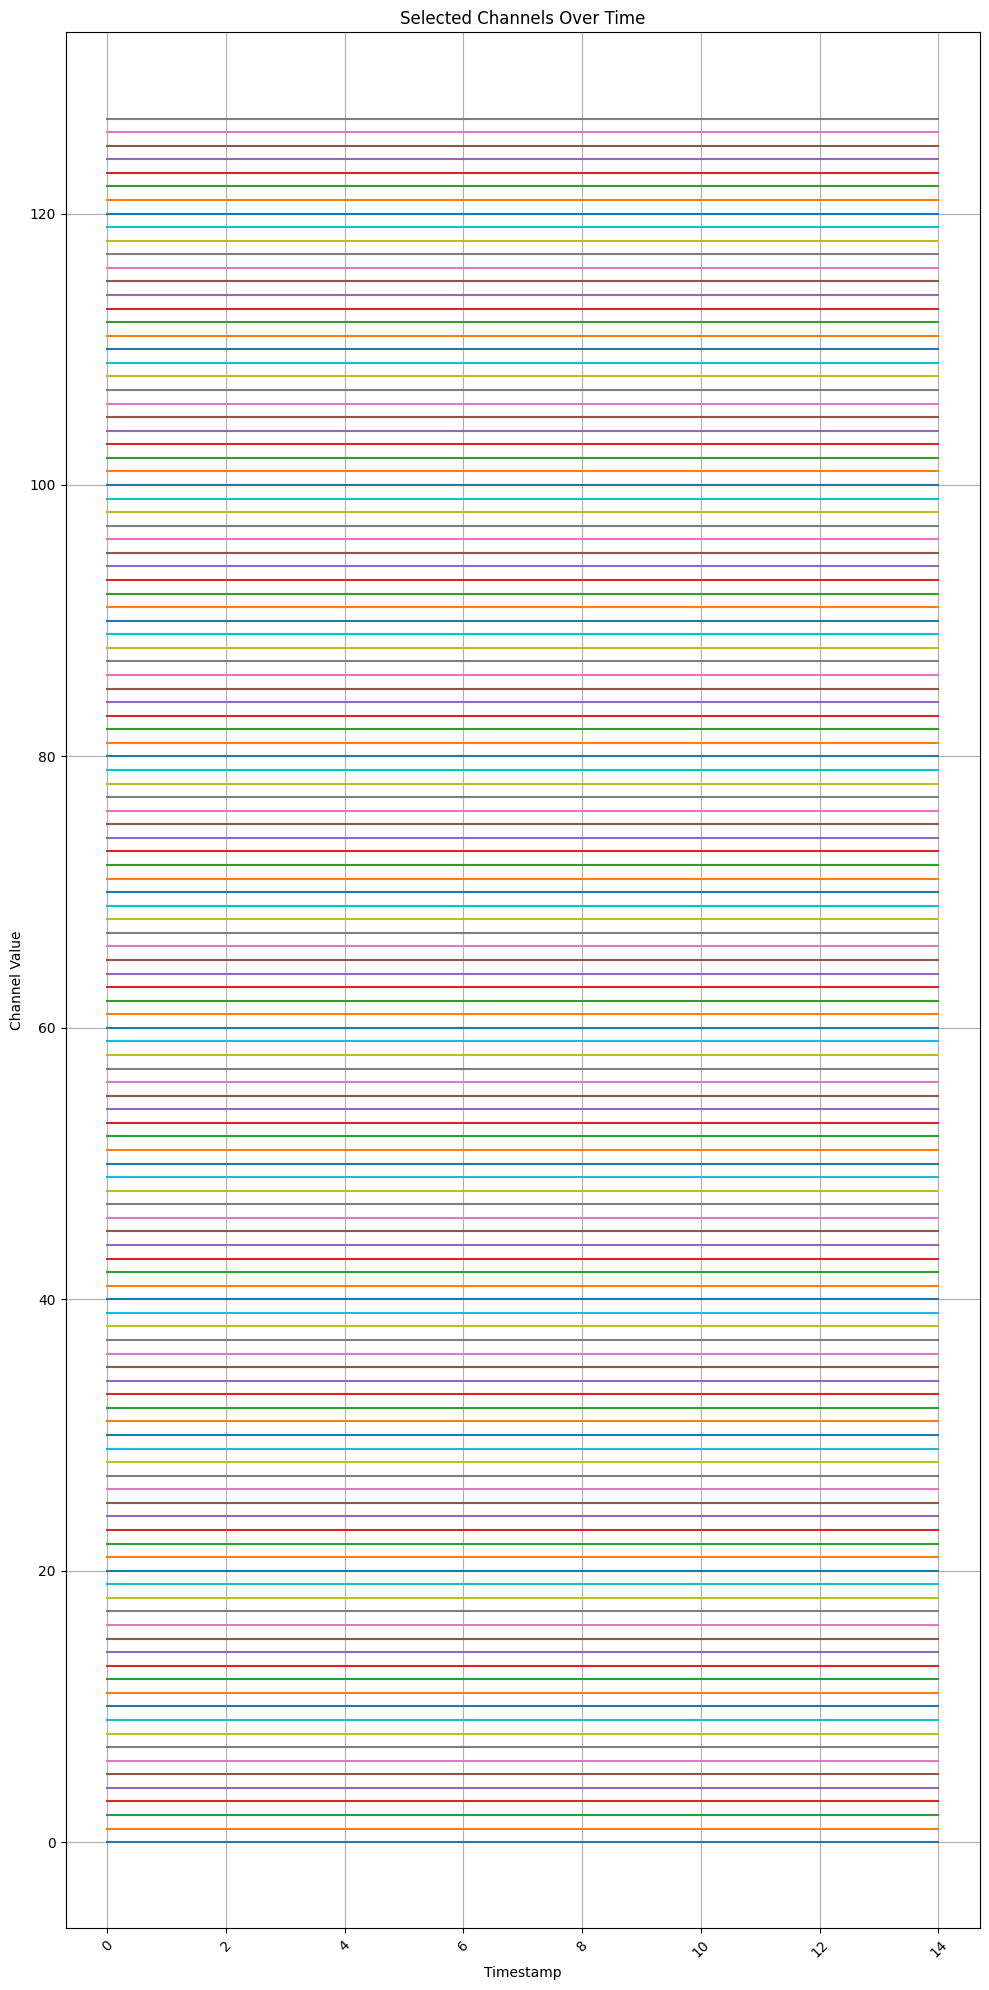

In [14]:
def parse_data_frames(file_path, num_data_streams):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    # data = [int(line.strip(), 16) for line in lines if line.strip()]
    data = [(int(line.strip(), 16) >> 16) & 0xFFFF for line in lines if line.strip()]
    # print([f"0x{w:04X}" for w in data[:50]])  # Print first 50 words in hex
    magic_sequence = [0x2A53, 0x3813, 0x2AAA, 0xD7A2]
    magic_len = len(magic_sequence)
    groups = []
    current_group = []
    i = 0
    while i < len(data):
        if data[i:i+magic_len] == magic_sequence:
            if current_group:
                groups.append(current_group)
            current_group = magic_sequence.copy()
            i += magic_len
        else:
            current_group.append(data[i])
            i += 1
    if current_group:
        groups.append(current_group)

    print("Number of Time entries",len(groups))
    print("Number of entries in frame ",len(groups[0]))
    # print([f"0x{w:04X}" for w in groups[0]])  # Print first 50 words in hex
    return groups

def parse_single_frame(frame, num_data_streams):
    """
    Parses a single frame into header, timestamp (32-bit), MISO data, ADC results, and TTL IO.

    frame: list of 16-bit integers
    num_data_streams: int, number of enabled data streams (1-32)
    """
    magic_sequence = [0x2A53, 0x3813, 0x2AAA, 0xD7A2]
    
    # Validate magic sequence
    if frame[:4] != magic_sequence:
        raise ValueError("Frame does not start with correct magic sequence!")
    
    # Timestamp is made from 5th and 6th entries
    timestamp_low  = frame[4]
    timestamp_high = frame[5]
    timestamp = (timestamp_high << 16) | timestamp_low
    # Start parsing after magic + timestamp
    idx = 6
    
    # Parse MISO data
    miso_entries_per_stream = 35  # 35 samples per data stream
    total_miso_entries = num_data_streams * miso_entries_per_stream
    miso_data =  frame[idx : idx + total_miso_entries]
    idx += total_miso_entries
    # Optional: parse filler words (skip 0-3 words if zeros)
    filler_words = 0
    while idx < len(frame) and frame[idx] == 0x0000:
        filler_words += 1
        idx += 1
    # print(f"Number of filler words: {filler_words}")
    # adc_results = frame[idx : idx + 8]
    # idx += 8
    # ttl_input =  frame[idx] if idx < len(frame) else None
    # ttl_output = frame[idx+1] if idx+1 < len(frame) else None
    # Package result
    parsed = {
        'timestamp': timestamp,
        'miso_data': miso_data,
        'filler_words': filler_words
    }
    return parsed



# def build_channel_aux_timestamp_arrays(frames, num_data_streams=4):
#     """
#     Parses multiple frames into timestamp array, channel array, and aux output array.

#     frames: list of frames (each a list of 16-bit integers)
#     num_data_streams: how many streams were enabled (default 4)
#     """
#     timestamps = []
#     channel_data = []  # List of [128 channels]
#     aux_data = []      # List of [12 aux values]

#     for frame in frames:
#         parsed = parse_single_frame(frame, num_data_streams)

#         timestamps.append(parsed['timestamp'])

#         miso_data = parsed['miso_data']
        
#         # Now parse miso_data into 4 sets
#         frame_channels = []
#         frame_aux = []

#         idx = 0
#         for stream in range(num_data_streams):
#             # Extract 3 aux outputs
#             aux_outputs = miso_data[idx:idx+3]
#             frame_aux.extend(aux_outputs)
#             idx += 3

#             # Extract 32 channels
#             channels = miso_data[idx:idx+32]
#             frame_channels.extend(channels)
#             idx += 32

#         # Each frame now yields:
#         # - 12 aux entries (3 * 4)
#         # - 128 channel entries (32 * 4)

#         channel_data.append(frame_channels)
#         aux_data.append(frame_aux)

#     return timestamps, channel_data, aux_data

def build_channel_aux_timestamp_arrays(frames, num_data_streams=4):
    """
    Parses multiple frames into timestamp array, channel array, and aux output array
    following the corrected interleaved format.
    """
    timestamps = []
    channel_data = []  # List of [128 channels]
    aux_data = []      # List of [12 aux values]

    for frame in frames:
        parsed = parse_single_frame(frame, num_data_streams)

        timestamps.append(parsed['timestamp'])
        miso_data = parsed['miso_data']

        frame_channels = [0] * (32 * num_data_streams)  # 128 channels
        frame_aux = [0] * (3 * num_data_streams)         # 12 aux outputs

        # Now step through 35 entries (each entry has 4 streams)
        idx = 0
        for sample_num in range(35):
            for stream_num in range(num_data_streams):
                value = miso_data[idx]
                idx += 1

                if sample_num < 3:
                    # First 3 samples are AUX data
                    aux_index = sample_num * num_data_streams + stream_num
                    frame_aux[aux_index] = value
                else:
                    # Remaining samples are Channel data
                    ch_index = (sample_num - 3) + (stream_num * 32)
                    frame_channels[ch_index] = value

        channel_data.append(frame_channels)
        aux_data.append(frame_aux)

    return timestamps, channel_data, aux_data



import matplotlib.pyplot as plt

def plot_selected_channels(timestamps, channel_data, channels_to_plot=None,emulator=False):
    """
    Plots selected channels over time. 
    If channels_to_plot is None or 'all', plots all available channels.

    timestamps: list of timestamps (length = num_frames)
    channel_data: list of lists, each with 128 channel values
    channels_to_plot: list of integers (channel indices to plot, 0 to 127) or None/'all'
    """
    num_frames = len(timestamps)

    # Make sure timestamps and data align
    assert len(channel_data) == num_frames, "Mismatch between timestamps and channel data!"

    # Build x-axis
    x = timestamps

    # If channels_to_plot is None or 'all', plot all channels
    if channels_to_plot is None or channels_to_plot == 'all':
        channels_to_plot = list(range(len(channel_data[0])))
    plt.figure(figsize=(10, 20))
    i = []
    # For each channel to plot
    for ch in channels_to_plot:
        if ch < 0 or ch >= len(channel_data[0]):
            print(f"Warning: Channel {ch} out of range. Skipping.")
            continue

        # y-axis: extract this channel across all frames
        y = [frame[ch] for frame in channel_data]
        
        # print(f"Channel {ch} data: {y[-1:]}")  # Print last value for quick check
        i.append([ch, y[-1:][0]])
        plt.plot(x, y, label=f'Channel {ch}')
    if emulator:
        print("")
        print("Checking channel alignment...")
        NO_PROBLEM = False
        for ie in i:
            if ie[1] != ie[0]:
                print(f"Channel MISSALIGHNMENT {ie[0]}: {ie[1]}")
                NO_PROBLEM = True
        if NO_PROBLEM:  
            print("Channel data is not aligned!")
        else:
            print("Done Checking channel alignment")
            print("Channel data is aligned!")
        print("")

    # print(i)
    plt.xlabel('Timestamp')
    plt.ylabel('Channel Value')
    plt.title('Selected Channels Over Time')
    # plt.legend()
    # plt.ylim(-32768, 32767)  # Assuming signed 16-bit values
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()


# Example usage:
a =  parse_data_frames("output_emulator_v1.txt", 4)
# a = parse_data_frames("output_hardcoded.txt", 4)
parsed = parse_single_frame(a[9], num_data_streams=4)
print("Timestamp:",                 parsed['timestamp'])
print("MISO data entries:",         parsed['miso_data'])
print("Len MISO data entries:", len(parsed['miso_data']))
print("Number of Filler Words:",    parsed['filler_words'])
timestamps, channel_data, aux_data = build_channel_aux_timestamp_arrays(a, num_data_streams=4)

print("Number of timestamps:", len(timestamps))
print("Shape of channel data:", len(channel_data), "x", len(channel_data[0]))
print("Shape of aux data:", len(aux_data), "x", len(aux_data[0]))

channels_to_plot = [0, 1, 2, 3]  # You can customize this
channels_to_plot = [2, 3, 4, 5]  # You can customize this

# plot_selected_channels(timestamps, channel_data, channels_to_plot)
plot_selected_channels(timestamps, channel_data, channels_to_plot='all',emulator=True)



Number of Time entries 255
Number of entries in frame  156
Timestamp: 9
MISO data entries: [32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770, 32771, 32772, 32769, 32770

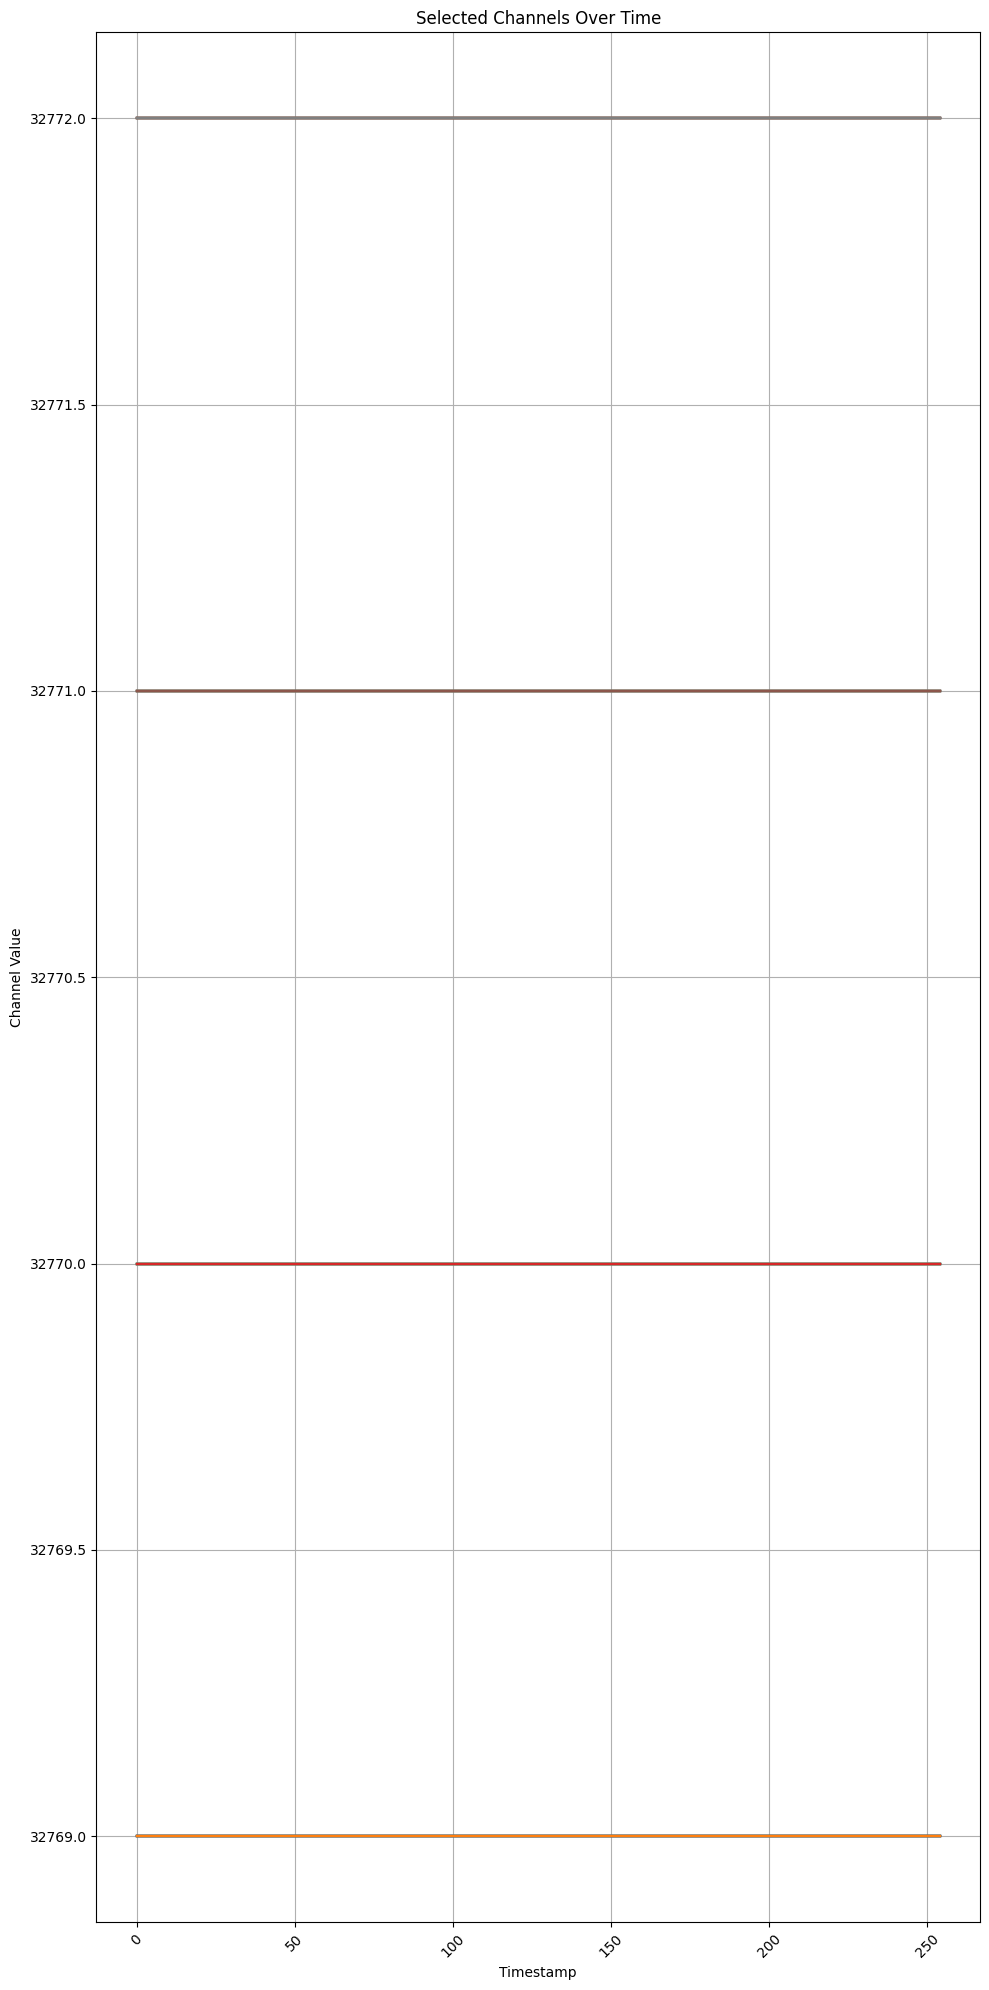

In [11]:
# Example usage:
# a =  parse_data_frames("output_emulator.txt", 4)
a = parse_data_frames("output_hardcoded.txt", 4)
parsed = parse_single_frame(a[9], num_data_streams=4)
print("Timestamp:",                 parsed['timestamp'])
print("MISO data entries:",         parsed['miso_data'])
print("Len MISO data entries:", len(parsed['miso_data']))
print("Number of Filler Words:",    parsed['filler_words'])
timestamps, channel_data, aux_data = build_channel_aux_timestamp_arrays(a, num_data_streams=4)

print("Number of timestamps:", len(timestamps))
print("Shape of channel data:", len(channel_data), "x", len(channel_data[0]))
print("Shape of aux data:", len(aux_data), "x", len(aux_data[0]))

# print("Timestamp 0:", timestamps[0])
# print("First 10 channel values at timestamp 0:", channel_data[0][:10])
# print("First 10 aux values at timestamp 0:", aux_data[0][:10])
channels_to_plot = [0, 1, 2, 3]  # You can customize this
channels_to_plot = [2, 3, 4, 5]  # You can customize this

# plot_selected_channels(timestamps, channel_data, channels_to_plot)

plot_selected_channels(timestamps, channel_data, channels_to_plot='all')